In [70]:
#DECLARAÇÃO DE BIBLIOTECAS

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.metrics import classification_report

In [274]:
#GERAÇÃO DE DADOS 

X = np.random.randn(1000, 2)
y = np.array(np.logical_xor(X[:, 0] > 0, X[:, 1] > 0), dtype=int)
Y=y
y = y.reshape(len(y),1)

#separação dos dados em conjuntos de treinamento e validação
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

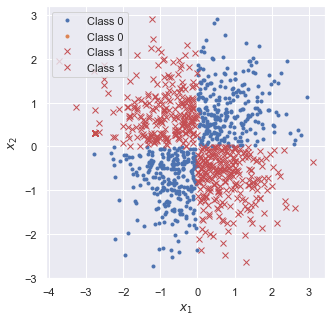

In [252]:
#PLOT GRAFICO DOS DADOS GERADOS

idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)

fig = plt.figure(figsize=(5,5))
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()

ANALISANDO O GRÁFICO ACIMA, A FRONTEIRA DE DECISÃO NECESSÁRIA PARA SEPARAR ESSAS CLASSES É NÃO-LINEAR

In [163]:
#DECLARAÇÃO DE ALGUMAS FUNÇÕES UTEIS

def error_function(x, a, y):    
    h = expit(x.dot(a))
    error = -(1/len(y))*np.sum( y.T.dot(np.log(h)) + (1-y).T.dot(np.log((1-h) )) )
    return error

def classifier(x, a):
    h = expit(x.dot(a))
    c = np.zeros((len(h), 1))
    for i in range(0, len(h)):
        if(h[i] >= 0.5):
            c[i,0]=1.0
    return c

def predict_prob(x, a):
    h1 = expit(x.dot(a))
    h0 = 1 - h1
    h = np.c_[h0, h1]
    return h

GRADIENTE DESCENDENTE EM BATELADA COM FUNÇÃO LINEAR E EARLYSTOPPING

In [67]:
#ADICIONANDO VETOR COLUNA DE 1 PARA O PARAMETRO a0

x_train = np.c_[np.ones((len(y_train), 1)), x_train]

x_test = np.c_[np.ones((len(y_test), 1)), x_test]

In [63]:
#ALGORITMO GRADIENTE DESCENDENTE EM BATELADA

#alpha = 5 #fator de aprendizagem muito grande
#alpha = 1 #fator de aprendizagem grande
alpha = 0.5 #melhor fator de aprendizagem
#alpha = 0.1 #fator de aprendizagem muito pequeno
#alpha = 0.01 #fator de aprendizagem muito pequeno

n_iterations = 1000 #número de iterações

a = np.random.randn(x_train.shape[1],1) #inicialização dos parâmetros

#criação dados de erro
Jgd = np.zeros(n_iterations+1)
Jgd_v = np.zeros(n_iterations+1)


#calculando erro inicial
Jgd[0] = error_function(x_train, a, y_train)
Jgd_v[0] = error_function(x_test, a, y_test)

#GRADIENTE DESCENDENTE EM BATELADA
minimum_val_error = float("inf")
iteration = 0
error = 1
while ((iteration < n_iterations) and error > 0.001):
    gradients = -1/len(y_train)*x_train.T.dot(y_train - expit(x_train.dot(a)) )
    a = a - alpha * gradients
    Jgd[iteration+1] = error_function(x_train, a, y_train)
    Jgd_v[iteration+1] = error_function(x_test, a, y_test)
    error = np.abs(Jgd[iteration+1] - Jgd[iteration])
    # Store weights for the smallest error ever.
    if(Jgd_v[iteration+1] < minimum_val_error):
        minimum_val_error = Jgd_v[iteration+1]
        a_min = a        
    iteration = iteration + 1

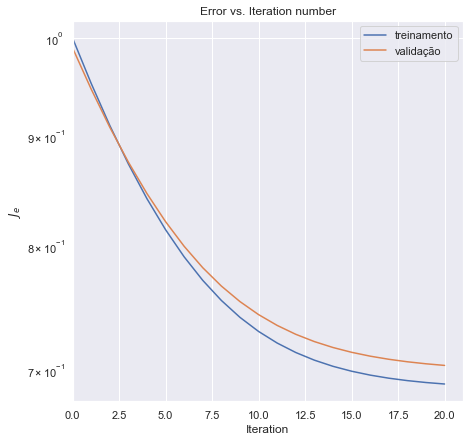

In [39]:
#PLOT ERRO vs ITERAÇÃO

fig = plt.figure(figsize=(7,7))
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

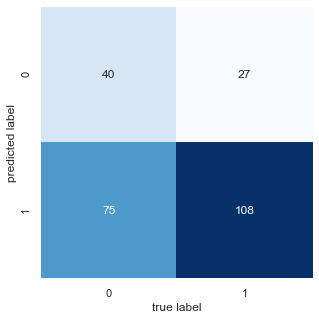

In [40]:
#PLOT MATRIZ DE CONFUSAO

y_pred_class = classifier(x_test, a_min)

# Plot the confusion matrix
fig = plt.figure(figsize=(5,5))
mat = confusion_matrix(y_test, y_pred_class)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1'], yticklabels=['0','1'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

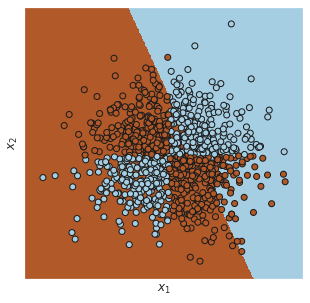

In [44]:
#PLOT FRONTEIRAS DE DECISAO

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = classifier(np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()], a_min)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(5, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

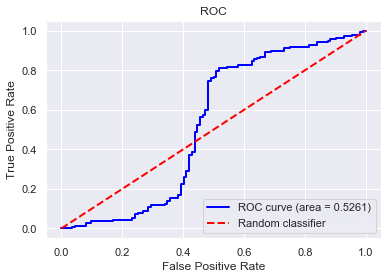

In [52]:
#PLOT CURVA ROC

# Getting the probabilities for each class.
y_prob = predict_prob(x_test, a_min)
# Calculating ROC curve and ROC AUC.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
# Plotting ROC curve.
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [53]:
#METRICAS

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.52      0.31      0.39       112
           1       0.58      0.77      0.66       138

    accuracy                           0.56       250
   macro avg       0.55      0.54      0.53       250
weighted avg       0.55      0.56      0.54       250



GRADIENTE DESCENDENTE EM BATELADA COM FUNÇÃO f(a0 + a1x1² - a2x2²) E EARLYSTOPPING 

ESTOU TENTANDO IMPLEMENTAR A FUNÇÃO DA HIPÉRBOLE [(X²/A²)-(Y²/B²) = 1] COM EIXO DE ROTAÇÃO DE -45º

DEVE FICAR BOM, PORÉM NÃO PERFEITO DEVIDO AO NÃO MODELAMENTO PERFEITO DO CONJUNTO DE DADOS POR UMA FUNÇÃO HIPERBÓLICA

In [275]:
#ADICIONANDO VETOR COLUNA DE 1 PARA O PARAMETRO a0 e x1² x2² para parametros a3 e a4

x_train = np.c_[np.ones((len(y_train), 1)), ((x_train[:,0]*0.707 + x_train[:,1]*0.707)**2), -((x_train[:,0]*(-0.707))+(x_train[:,1]*0.707)**2)]

x_test = np.c_[np.ones((len(y_test), 1)), ((x_test[:,0]*0.707 + x_test[:,1]*0.707)**2), -((x_test[:,0]*-(0.707))+(x_test[:,1]*0.707)**2)]

In [283]:
#ALGORITMO GRADIENTE DESCENDENTE EM BATELADA

#alpha = 5 #fator de aprendizagem muito grande
#alpha = 1 #fator de aprendizagem grande
#alpha = 0.5 #melhor fator de aprendizagem
alpha = 0.1 #fator de aprendizagem pequeno
#alpha = 0.01 #fator de aprendizagem muito pequeno

n_iterations = 1000 #número de iterações

a = np.random.randn(x_train.shape[1],1) #inicialização dos parâmetros

#criação dados de erro
Jgd = np.zeros(n_iterations+1)
Jgd_v = np.zeros(n_iterations+1)


#calculando erro inicial
Jgd[0] = error_function(x_train, a, y_train)
Jgd_v[0] = error_function(x_test, a, y_test)

#GRADIENTE DESCENDENTE EM BATELADA
minimum_val_error = float("inf")
iteration = 0
error = 1
while (iteration < n_iterations):
    gradients = -1/len(y_train)*x_train.T.dot(y_train - expit(x_train.dot(a)) )
    a = a - alpha * gradients
    Jgd[iteration+1] = error_function(x_train, a, y_train)
    Jgd_v[iteration+1] = error_function(x_test, a, y_test)
    error = np.abs(Jgd[iteration+1] - Jgd[iteration])
    # Store weights for the smallest error ever - EARLY STOPPING
    if(Jgd_v[iteration+1] < minimum_val_error):
        minimum_val_error = Jgd_v[iteration+1]
        a_min = a        
    iteration = iteration + 1
    
print(len(a))
print(a_min)

3
[[ 1.00869158]
 [-1.81500709]
 [-0.79686786]]


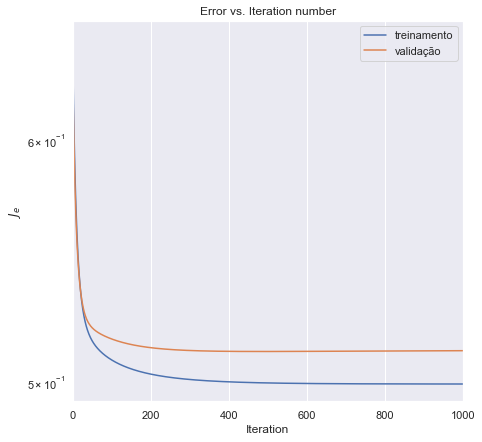

In [284]:
#PLOT ERRO vs ITERAÇÃO

fig = plt.figure(figsize=(7,7))
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.show()

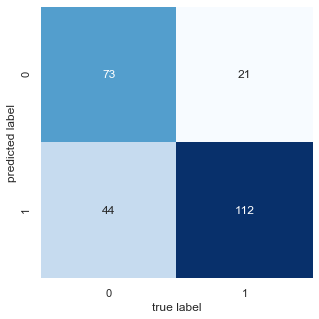

In [285]:
#PLOT MATRIZ DE CONFUSAO

y_pred_class = classifier(x_test, a_min)

# Plot the confusion matrix
fig = plt.figure(figsize=(5,5))
mat = confusion_matrix(y_test, y_pred_class)
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1'], yticklabels=['0','1'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

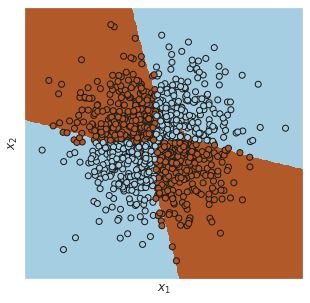

In [286]:
#PLOT FRONTEIRAS DE DECISAO

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 #x1
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 #x2
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = classifier(np.c_[np.ones((len(xx.ravel()), 1)), (xx.ravel()*0.707 + yy.ravel()*0.707)**2, -(xx.ravel()*(-0.707) + yy.ravel()*0.707)**2], a_min)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(5, 5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

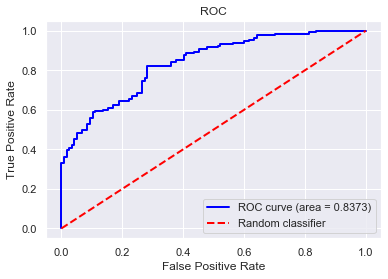

In [287]:
#PLOT CURVA ROC

# Getting the probabilities for each class.
y_prob = predict_prob(x_test, a_min)
# Calculating ROC curve and ROC AUC.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
# Plotting ROC curve.
lw = 2
plt.plot(false_positive_rate, true_positive_rate, color='blue', lw=lw, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [288]:
#METRICAS

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.78      0.62      0.69       117
           1       0.72      0.84      0.78       133

    accuracy                           0.74       250
   macro avg       0.75      0.73      0.73       250
weighted avg       0.75      0.74      0.74       250



O CLASSIFICADOR LINEAR NÃO CONSEGUE DISTINGUIR BEM UM CONJUNTO DE TREINAMENTOS QUE NÃO PODEM SER SEPARADO POR LINHAS RETAS, SUA PERFORMANCE FICA PARECIDA A UM CLASSIFICADOR RANDÔMICO (0.5).

UTILIZANDO UM CLASSIFICADOR NÃO-LINEAR (FUNÇÃO HIPERBÓLICA COM EIXO DE ROTAÇÃO DE -45º), O MODELO CONSEGUE CLASSIFICAR COM MAIS EXATIDÃO OS DADOS, PORÉM ELE NÃO FICA PERFEITO DEVIDO A UTILIZAÇÃO DA HIPÉRBOLE NORMAL (1) AO INVÉS DE UMA COM FOCO MAIS DISTANTE DO CENTRO E EQUAÇÃO MAIS MALEÁVEL.

